# Configs

In [ ]:
import random


random.seed(27)

splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Load data

In [ ]:
from utils.prepare_data import getMonitoredPatients
from pandas import Timedelta


patients = getMonitoredPatients()
patients.removePatientAkiEarly(Timedelta(hours=12))

print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

# Transformer

### Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TransformerEncoder(nn.Module):
    def __init__(
        self,
        n_feat,
        nhead,
        num_encoder_layers,
        dim_feedforward,
    ):
        super(TransformerEncoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=n_feat,
            batch_first=True,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=0.3,
            activation="relu",
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_encoder_layers
        )
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(x)
        output = self.transformer_encoder(x)
        return output


class TransformerModel(nn.Module):
    def __init__(
        self,
        n_feats,
        nhead,
        num_encoder_layers,
        dim_feedforward,
    ):
        super(TransformerModel, self).__init__()
        self.transformer_encoder = TransformerEncoder(
            n_feat=n_feats,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
        )
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(n_feats, 1)

    def forward(self, x):
        x = self.transformer_encoder(x)

        # Permute for pooling: (batch_size, seq_len, d_model) -> (batch_size, d_model, seq_len)
        x = x.permute(0, 2, 1)

        # Global Average Pooling
        x = self.pooling(x).squeeze(-1)

        x = self.fc1(x)
        return x


model = TransformerModel(
    n_feats=512,
    nhead=8,
    num_encoder_layers=2,
    dim_feedforward=200,
)

# Example input (batch_size, seq_len, d_model)
src = torch.rand(32, 100, 512)  # Batch of 32 sequences, each of length 100
output = model(src)
print(output.shape)  # Expected output: (32, 1)

torch.Size([32, 1])


### Train - test function

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_


def train(
    model,
    device,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    epochs=20,
    earlyStopping=5,
):
    model.to(device)

    optimScheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3)

    # early stopping
    bestValLoss = float("inf")
    bestModelState = None
    patience = 0

    trainLosses = []
    valLosses = []

    for epoch in range(epochs):
        model.train()
        trainLoss = 0

        for batchX, batchY in trainLoader:
            batchX, batchY = batchX.to(device), batchY.to(device)

            outputs = model(batchX)
            loss = criterion(outputs, batchY)

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            trainLoss += loss.item() * batchX.size(0)

        trainLoss /= len(trainLoader.dataset)
        trainLosses.append(trainLoss)

        # validation
        model.eval()
        valLoss = 0

        with torch.no_grad():
            for batchX, batchY in valLoader:
                batchX, batchY = batchX.to(device), batchY.to(device)

                outputs = model(batchX)
                loss = criterion(outputs, batchY)

                valLoss += loss.item() * batchX.size(0)

        valLoss /= len(valLoader.dataset)
        valLosses.append(valLoss)
        
        optimScheduler.step(valLoss)

        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestModelState = model.state_dict()
            patience = 0
        else:
            patience += 1

        print(
            f"Epoch {epoch+1}/{epochs} Train Loss: {trainLoss:.4f} Val Loss: {valLoss:.4f}"
        )

        if patience > earlyStopping:
            break

    model.load_state_dict(bestModelState)
    return model, trainLosses, valLosses


def predTest(model, device, testLoader):
    model.eval()

    predProbas = []
    actuals = []

    with torch.no_grad():
        for batchX, batchY in testLoader:
            batchX, batchY = batchX.to(device), batchY.to(device)

            outputs = model(batchX)
            probas = torch.sigmoid(outputs)
            predProbas.extend(probas.cpu().numpy())
            actuals.extend(batchY.cpu().numpy())

    return predProbas, actuals

2024-08-30 18:11:45.890684: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 18:11:45.898108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 18:11:45.904889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 18:11:45.907289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 18:11:45.914091: I tensorflow/core/platform/cpu_feature_guar

I0000 00:00:1725016306.665021 2579843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725016306.669033 2579843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725016306.669120 2579843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725016306.670476 2579843 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "array_to_boolean_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train and eval

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from utils.class_voter import combineProbas
from utils.prepare_data import (
    DeepLearningDataPreparer,
    trainValTestPatients,
)
import numpy as np


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 64

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        (
            (npTrainX, staticTrainX, trainY),
            (npValX, staticValX, valY),
            (npTestX, staticTestX, testY),
        ) = preparer.trainValTest(trainPatients, valPatients, testPatients)

        # neg, pos = np.bincount(trainY)
        # weight0 = (1 / neg) * (len(trainY)) / 2.0
        # weight1 = (1 / pos) * (len(trainY)) / 2.0
        # weight = {0: weight0, 1: weight1}

        # expand static data to be same size as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)
        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        # create data loader
        trainLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTrainX).float(),
                torch.tensor(trainY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=True,
        )
        valLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npValX).float(),
                torch.tensor(valY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )
        testLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTestX).float(),
                torch.tensor(testY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )

        model = TransformerModel(
            n_feats=npTrainX.shape[2],
            nhead=8,
            num_encoder_layers=2,
            dim_feedforward=124,
        )
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

        _, trainLosses, valLosses = train(
            model,
            device,
            trainLoader,
            valLoader,
            criterion,
            optimizer,
            epochs=50,
            earlyStopping=10,
        )

        models.append(model)
        train_loss_list.append(trainLosses)
        val_loss_list.append(valLosses)

        predProbas, _ = predTest(model, device, testLoader)
        probas.append(predProbas)
        torch.save(model.state_dict(), f"result/transformer_only_model/{i}_{ii}.pt")

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

I0000 00:00:1725016309.308607 2579972 service.cc:146] XLA service 0x7364480037e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725016309.308625 2579972 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-30 18:11:49.353913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-30 18:11:49.373483: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. array_to_boolean_model_1_1/transformer_encoder_1/layer_0/self_attention/dropout_3/dropout/random_uniform/RandomUniform


2024-08-30 18:11:49.771954: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


2024-08-30 18:11:50.325077: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 60 bytes spill stores, 60 bytes spill loads

2024-08-30 18:11:50.414440: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 188 bytes spill stores, 188 bytes spill loads

2024-08-30 18:11:50.499039: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 380 bytes spill stores, 328 bytes spill loads



I0000 00:00:1725016312.216049 2579972 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2024-08-30 18:11:53.141649: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 48 bytes spill stores, 48 bytes spill loads

2024-08-30 18:11:53.212317: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 12 bytes spill stores, 12 bytes spill loads

2024-08-30 18:11:53.233280: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads

2024-08-30 18:11:53.277495: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 24 bytes spill stores, 24 bytes spill loads



2024-08-30 18:11:53.372904: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 676 bytes spill stores, 484 bytes spill loads



2024-08-30 18:11:56.867034: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 48 bytes spill stores, 48 bytes spill loads

2024-08-30 18:11:56.940675: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads



2024-08-30 18:11:57.124775: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 676 bytes spill stores, 484 bytes spill loads




1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 842ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 768ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 775ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 792ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 793ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step 


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


2024-08-30 18:15:09.883951: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 20 bytes spill stores, 20 bytes spill loads

2024-08-30 18:15:09.957352: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 132 bytes spill stores, 132 bytes spill loads



2024-08-30 18:15:10.120259: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 348 bytes spill stores, 296 bytes spill loads



2024-08-30 18:15:12.970319: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 4 bytes spill stores, 4 bytes spill loads

2024-08-30 18:15:13.000972: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 4 bytes spill stores, 4 bytes spill loads

2024-08-30 18:15:13.002390: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 204 bytes spill stores, 204 bytes spill loads

2024-08-30 18:15:13.094450: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 620 bytes spill stores, 408 bytes spill loads



2024-08-30 18:15:16.453052: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 204 bytes spill stores, 204 bytes spill loads

2024-08-30 18:15:16.543886: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 620 bytes spill stores, 408 bytes spill loads




1/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 794ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 776ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 779ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 778ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


2024-08-30 18:19:56.918442: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 188 bytes spill stores, 188 bytes spill loads

2024-08-30 18:19:56.990145: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 60 bytes spill stores, 60 bytes spill loads



2024-08-30 18:19:57.120227: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 380 bytes spill stores, 328 bytes spill loads



2024-08-30 18:20:00.007314: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 48 bytes spill stores, 48 bytes spill loads

2024-08-30 18:20:00.072490: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 80 bytes spill stores, 80 bytes spill loads

2024-08-30 18:20:00.085224: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 48 bytes spill stores, 48 bytes spill loads

2024-08-30 18:20:00.109978: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads

2024-08-30 18:20:00.197106: I external/local_xla/xla/stream_executor/c

2024-08-30 18:20:03.623591: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 48 bytes spill stores, 48 bytes spill loads

2024-08-30 18:20:03.674920: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads



2024-08-30 18:20:03.868237: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 676 bytes spill stores, 484 bytes spill loads




1/8 ━━━━━━━━━━━━━━━━━━━━ 6s 870ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 783ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 758ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 806ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 798ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 802ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 772ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 784ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 767ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 787ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


2024-08-30 18:28:10.714435: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 188 bytes spill stores, 188 bytes spill loads

2024-08-30 18:28:10.728090: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 80 bytes spill stores, 80 bytes spill loads



2024-08-30 18:28:10.944470: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 676 bytes spill stores, 484 bytes spill loads




1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 798ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  



1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 792ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  



1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 797ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  



1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 800ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  



1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 787ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


In [13]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.8072732371104886 +- 0.01658864924513635 [0.8335949764521193, 0.7936507936507937, 0.8081324778914514, 0.8147216923877232, 0.7862662451703548]
Accuracy: 0.7304087301587302 +- 0.03811980771841313 [0.7955555555555556, 0.7466666666666667, 0.6844444444444444, 0.7155555555555555, 0.7098214285714286]
Specificity: 0.7128692572919578 +- 0.07416241077343866 [0.8163265306122449, 0.7891156462585034, 0.6506849315068494, 0.6643835616438356, 0.6438356164383562]
Precision: 0.5941686818118826 +- 0.05494053029831608 [0.686046511627907, 0.6265060240963856, 0.5363636363636364, 0.5663716814159292, 0.5555555555555556]
Recall: 0.7626744563453424 +- 0.057882624983912105 [0.7564102564102564, 0.6666666666666666, 0.7468354430379747, 0.810126582278481, 0.8333333333333334]
AUC PR: 0.6856751281568695 +- 0.02599094704707963 [0.7291953378111595, 0.6695855509540594, 0.700366362346464, 0.6724182102266357, 0.6568101794460286]


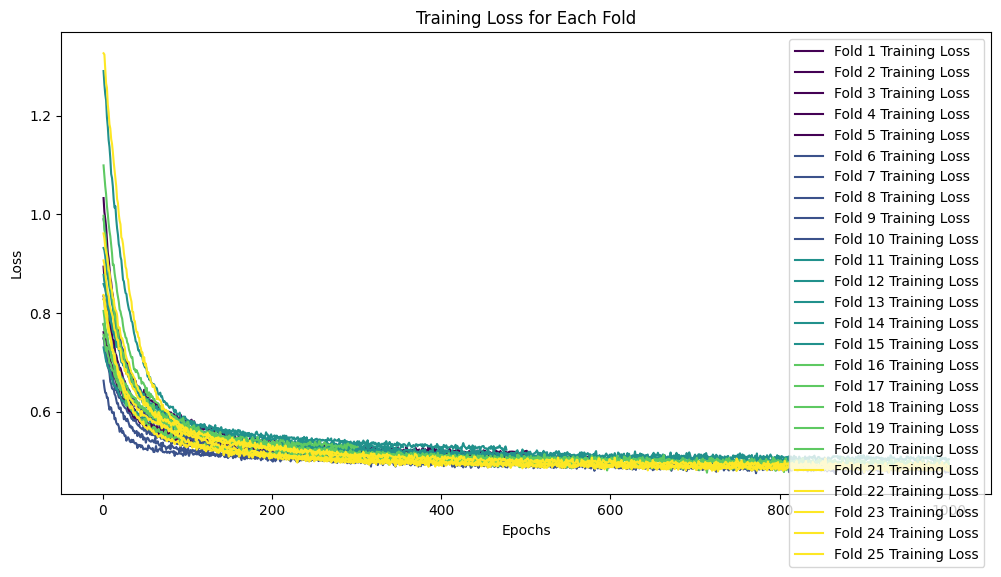

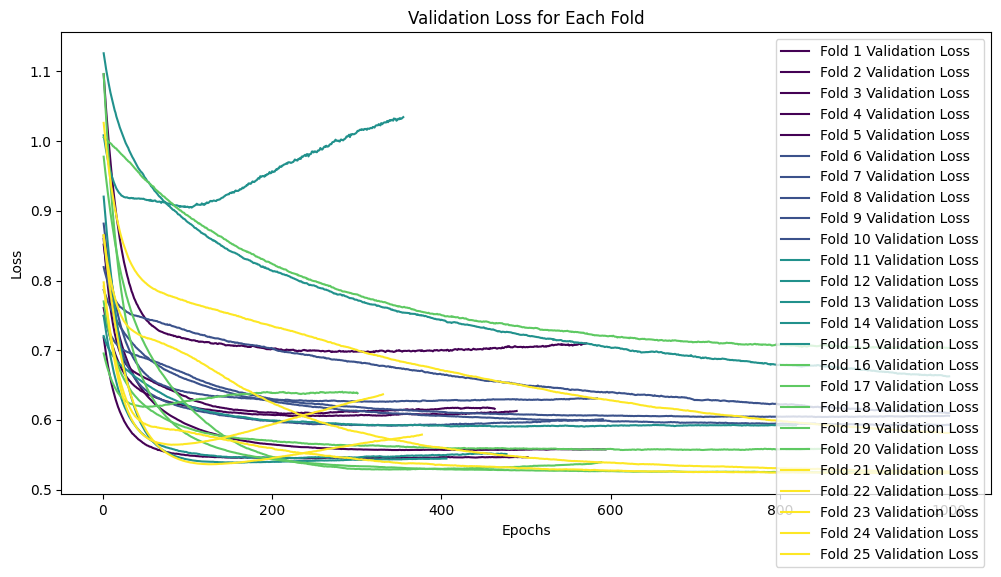

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_only_val_loss.svg")
plt.show()